# BullEx Stock Prediction
# Contributors: Sri Hari, Arun Kumar, Zahra

## Import Neccessary Libraries:


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Data Collection

This code fetches historical stock price data for a specified ticker symbol within a given date range. The fetch_data function uses the yfinance library to download stock data for the ticker 'AAPL' (Apple Inc.) from January 1, 2010, to December 31, 2022, and returns it as a DataFrame.

In [24]:
# Fetch historical stock price data
def fetch_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df

# Fetch and preprocess data
ticker = 'ZOM'
start_date = '2017-11-20'
end_date = '2023-12-31'
df = fetch_data(ticker, start_date, end_date)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-21,2.350,2.45,2.180,2.389,2.389,18100
2017-11-22,2.409,2.43,2.395,2.395,2.395,16000
2017-11-24,2.400,2.40,2.380,2.380,2.380,3100
2017-11-27,2.400,2.40,2.336,2.400,2.400,10500
2017-11-28,2.400,2.40,2.357,2.400,2.400,700


## Preprocess data

This code preprocesses historical stock price data by performing the following steps:

Select Close Prices: Extracts only the 'Close' column from the DataFrame.<br>
Scale Data: Uses MinMaxScaler to normalize the 'Close' prices to a range between 0 and 1.<br>
Split Data: Splits the scaled data into training and testing sets, with 80% of the data used for training and 20% for testing.<br>

In [26]:
# Preprocess data
def preprocess_data(df):
    df = df[['Close']]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    return train_data, test_data, scaler

train_data, test_data, scaler = preprocess_data(df)

## Create input sequences for RNN

This code prepares historical stock price data for training an RNN model. It first creates sequences of a specified length (60 days) from the normalized closing prices, where each sequence is used as input (X), and the next day’s price is the target (y). The sequences are generated separately for training and testing datasets. Finally, the input sequences are reshaped into 3D arrays to fit the RNN input requirements, ensuring the data is properly structured for the model.

In [27]:
# Create sequences for RNN input
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data for RNN input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Model Development

This code trains an enhanced RNN model for stock price prediction using Bidirectional LSTM layers and Dropout. The model architecture includes three Bidirectional LSTM layers, each with 50 units, to capture temporal dependencies in both forward and backward directions. Dropout layers with a 0.2 rate are added after each LSTM layer to prevent overfitting. A dense layer with a single neuron serves as the output layer. The model is compiled with the Adam optimizer and Mean Squared Error loss, then trained on the provided data for a specified number of epochs with a batch size of 32. The function returns the trained model.

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_rnn_model(X_train, y_train, epochs):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=50)))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

    return model

## Experimenting with Epoch Values for RNN Stock Price Prediction


This code tests different epoch values to train an RNN model for stock price prediction and evaluates its performance. It trains the model using various epoch values, makes predictions on test data, and inverse transforms these predictions to the original scale. It then calculates and stores the Mean Squared Error (MSE) and Mean Absolute Error (MAE) for each epoch value, printing these metrics to identify the optimal training duration.

In [48]:
# List of epoch values to experiment with
epoch_values = [10, 50, 100, 150, 200]
predictions_dict = {}
performance_dict_mse = {}
performance_dict_mae = {}

# Inverse transform actual data
actual_prices = scaler.inverse_transform(test_data[seq_length:])

# Reshape y_test to 2D array
y_test_reshaped = y_test.reshape(-1, 1)

# Train the model and make predictions for each epoch value
for epochs in epoch_values:
    model = train_rnn_model(X_train, y_train, epochs)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    predictions_dict[epochs] = predictions

    # Calculate performance
    mse = mean_squared_error(scaler.inverse_transform(y_test_reshaped), predictions)
    mae = mean_absolute_error(scaler.inverse_transform(y_test_reshaped), predictions)
    performance_dict_mse[epochs] = mse
    performance_dict_mae[epochs] = mae

    print(f'Epochs: {epochs}, Mean Squared Error: {mse}, Mean Absolute Error: {mae}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Epochs: 10, Mean Squared Error: 0.0005985609323708763, Mean Absolute Error: 0.020947252790774064


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epochs: 50, Mean Squared Error: 0.00032152168364587766, Mean Absolute Error: 0.015203051569481051


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Epochs: 100, Mean Squared Error: 0.00010628590619730608, Mean Absolute Error: 0.0075206328183412535


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Epochs: 150, Mean Squared Error: 0.00010211968051761534, Mean Absolute Error: 0.006664575408062627


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Epochs: 200, Mean Squared Error: 0.0007550788156367618, Mean Absolute Error: 0.026170044236125484


## Identifying Optimal Epochs for Model Performance

This code identifies the optimal number of epochs for training the RNN model by finding the epoch values that yield the lowest Mean Squared Error (MSE) and Mean Absolute Error (MAE). It then prints the best epoch values based on these performance metrics to highlight the most effective training duration for the model.

In [49]:
# Find the epoch value with the best performance
best_epochs_mse = min(performance_dict_mse, key=performance_dict_mse.get)
best_epochs_mae = min(performance_dict_mae, key=performance_dict_mae.get)

# Print the best model details
print(f'The best model according to Mean Squared Error: {best_epochs_mse} epochs and Mean Absolute Error: {best_epochs_mae}.')

The best model according to Mean Squared Error: 150 epochs and Mean Absolute Error: 150.


## Visualizing Stock Price Predictions

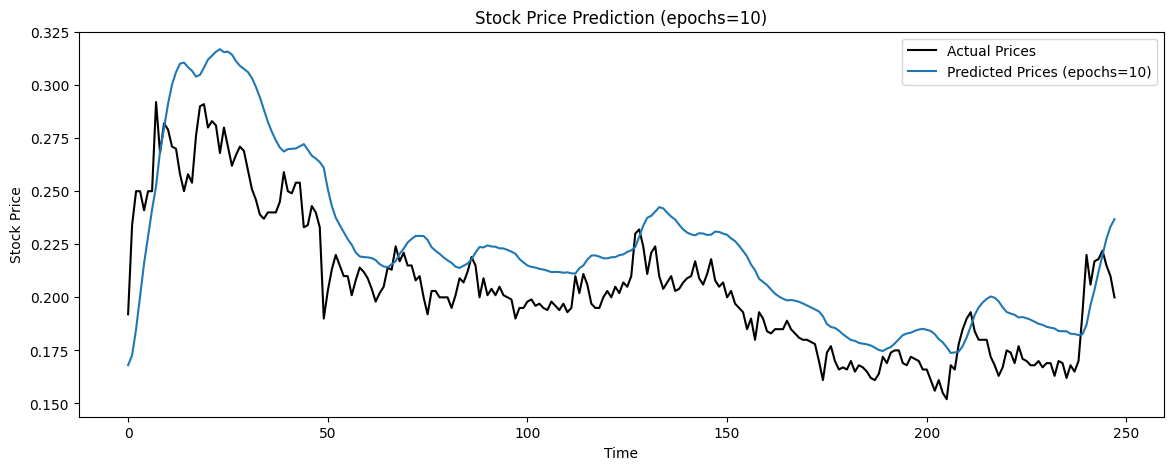

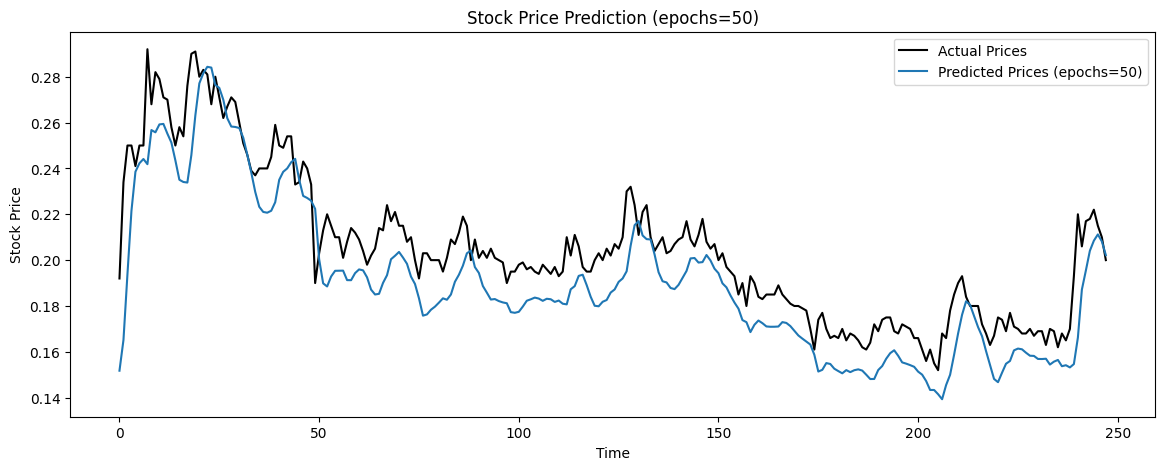

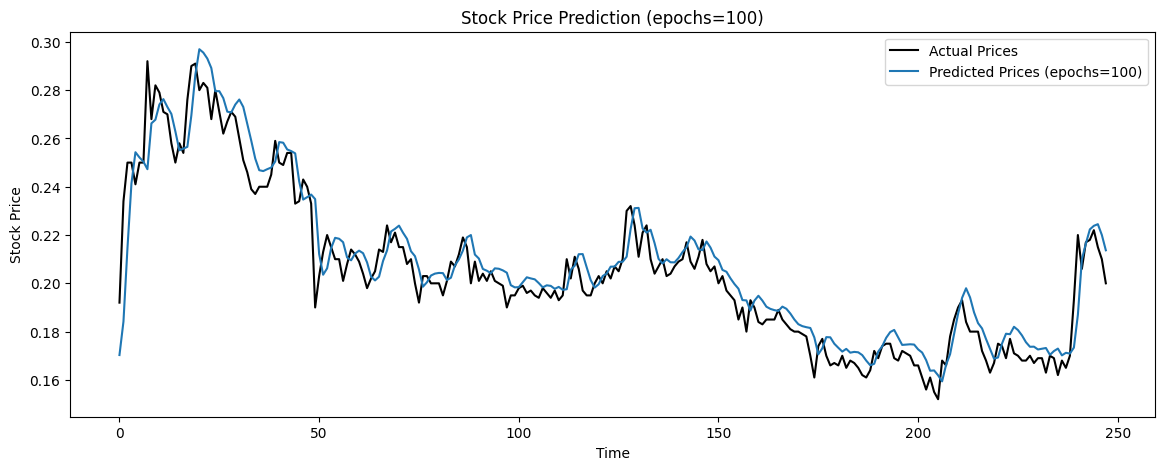

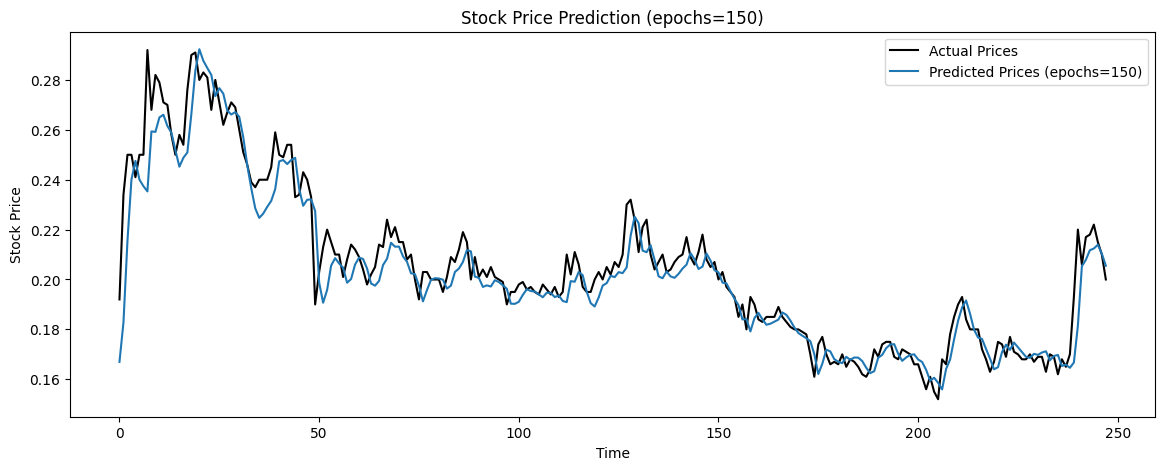

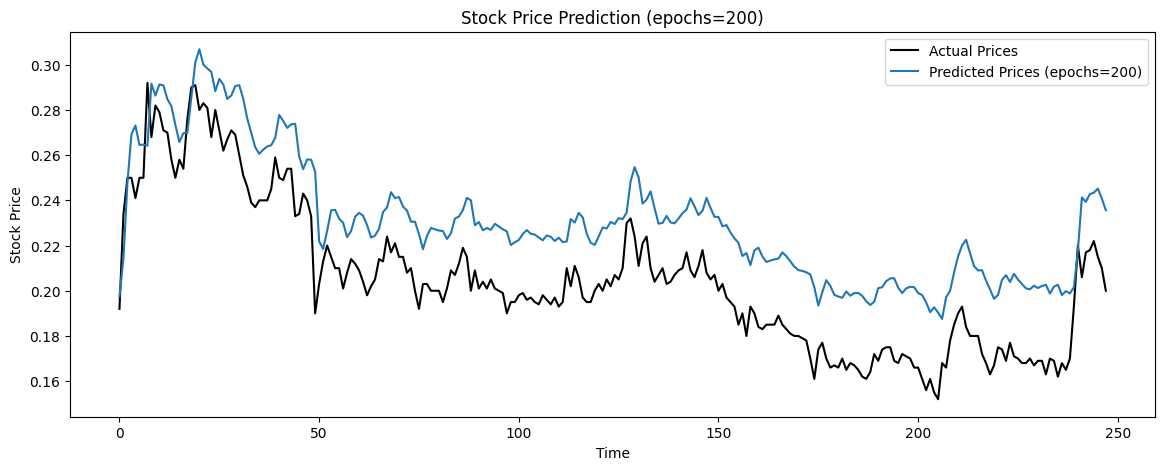

In [50]:
# Plot predictions vs actual prices
for epochs, predictions in predictions_dict.items():
    plt.figure(figsize=(14, 5))
    plt.plot(actual_prices, color='black', label='Actual Prices')
    plt.plot(predictions, label=f'Predicted Prices (epochs={epochs})')
    plt.title(f'Stock Price Prediction (epochs={epochs})')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

10 0.23679848
50 0.20220128
100 0.21368314
150 0.20553297
200 0.23562454


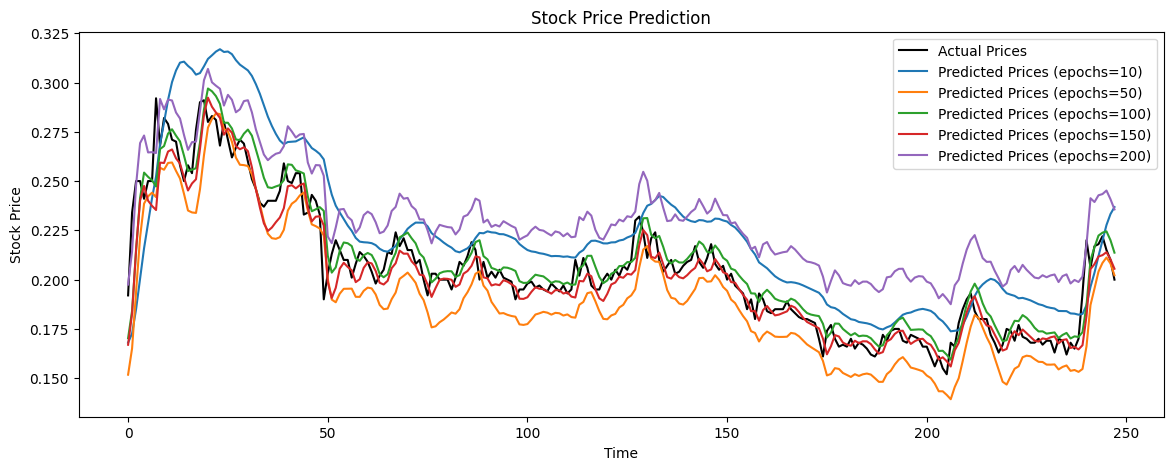

In [51]:
# Plot predictions vs actual prices
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='black', label='Actual Prices')

for epochs, predictions in predictions_dict.items():
    plt.plot(predictions, label=f'Predicted Prices (epochs={epochs})')
    print(epochs, predictions[-1, 0])

plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

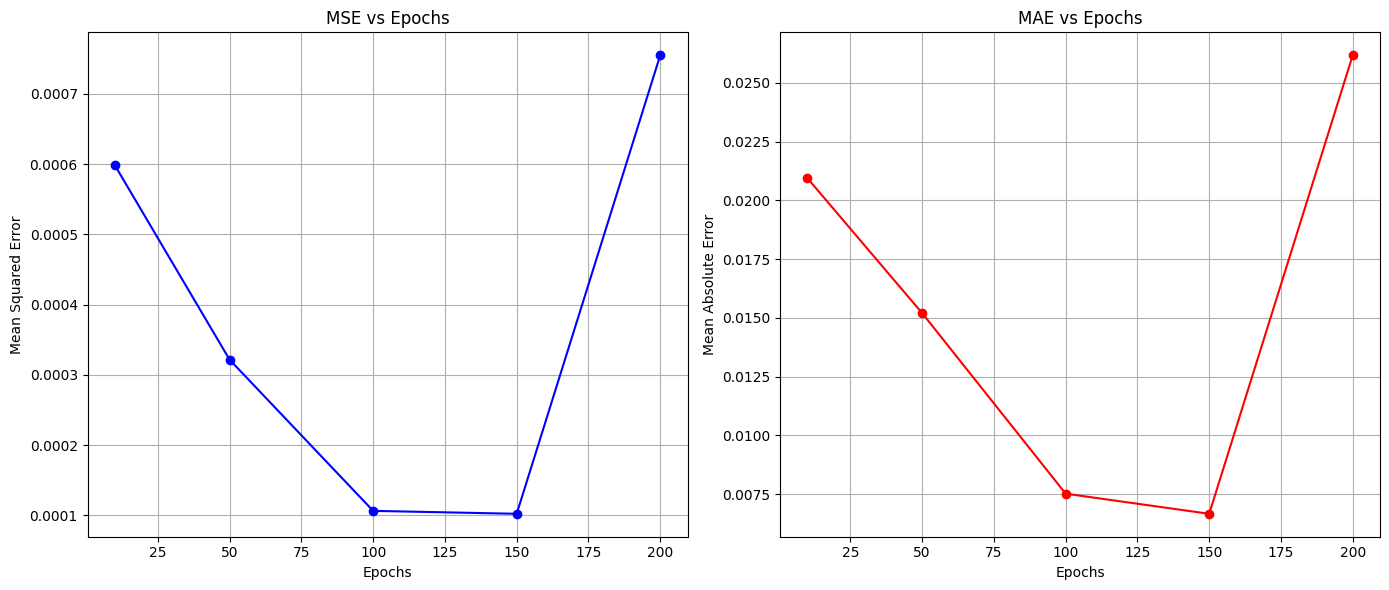

In [52]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(list(performance_dict_mse.keys()), list(performance_dict_mse.values()), marker='o', color='blue')
plt.title('MSE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.grid(True)

# Plot Mean Absolute Error (MAE)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(list(performance_dict_mae.keys()), list(performance_dict_mae.values()), marker='o', color='red')
plt.title('MAE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid(True)

plt.tight_layout()
plt.show()

## Saving the Optimal RNN Model

In [53]:
best_epochs = 150  # Chosen after analysing the results
best_model = train_rnn_model(X_train, y_train, best_epochs)

# Save the best model
best_model.save('stock_prediction_rnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
